In [1]:
!pip install pytorch-tabnet

In [2]:
from google import colab
colab.drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import numpy as np
import pandas as pd
from pytorch_tabnet.tab_model import TabNetClassifier
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import f1_score
import warnings
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler,StandardScaler
warnings.filterwarnings(action='ignore')

In [4]:
job_paths = '/content/drive/MyDrive/JobCare_data/'

train_df = pd.read_csv(job_paths + 'train.csv')
test_df = pd.read_csv(job_paths + 'test.csv')

In [5]:
train_df

,id,d_l_match_yn,d_m_match_yn,d_s_match_yn,h_l_match_yn,h_m_match_yn,h_s_match_yn,person_attribute_a,person_attribute_a_1,person_attribute_b,...,contents_attribute_k,contents_attribute_l,contents_attribute_d,contents_attribute_m,contents_attribute_e,contents_attribute_h,person_rn,contents_rn,contents_open_dt,target
0,0,True,True,True,False,False,False,1,4,3,...,2,1608,275,1,4,139,618822,354805,2020-01-17 12:09:36,1
1,1,False,False,False,True,True,False,1,3,4,...,2,1608,275,1,4,133,571659,346213,2020-06-18 17:48:52,0
2,2,False,False,False,True,False,False,2,0,3,...,1,1600,94,1,4,53,399816,206408,2020-07-08 20:00:10,0
3,3,False,False,False,True,False,False,2,0,2,...,2,1608,275,5,3,74,827967,572323,2020-01-13 18:09:34,0
4,4,True,True,True,False,False,False,1,3,4,...,2,1608,275,1,4,74,831614,573899,2020-03-09 20:39:22,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501946,501946,False,False,False,True,False,False,1,1,2,...,2,354,147,1,5,65,503156,285850,2020-03-13 12:55:52,1
501947,501947,True,True,False,True,False,False,1,6,2,...,2,163,120,1,4,142,676255,456996,2020-01-20 11:51:51,1
501948,501948,True,True,True,True,False,False,1,7,4,...,2,438,147,2,7,65,484528,293258,2020-08-05 17:27:24,1
501949,501949,True,False,False,True,False,False,1,1,2,...,2,660,147,3,4,259,456330,273797,2020-06-15 09:23:21,1


In [6]:
test_df

,id,d_l_match_yn,d_m_match_yn,d_s_match_yn,h_l_match_yn,h_m_match_yn,h_s_match_yn,person_attribute_a,person_attribute_a_1,person_attribute_b,...,contents_attribute_c,contents_attribute_k,contents_attribute_l,contents_attribute_d,contents_attribute_m,contents_attribute_e,contents_attribute_h,person_rn,contents_rn,contents_open_dt
0,0,True,False,False,True,True,True,1,1,2,...,1,2,1147,839,1,5,263,393790,236865,2020-12-01 02:24:18
1,1,False,False,False,True,False,False,2,0,2,...,1,2,1611,278,1,4,263,394058,236572,2020-12-17 05:42:53
2,2,True,False,False,True,True,True,2,3,2,...,1,2,1817,490,3,4,177,1002061,704612,2020-12-10 23:33:41
3,3,True,False,False,True,True,True,1,2,2,...,1,2,101,150,5,3,177,1000813,704652,2020-12-03 19:44:55
4,4,True,False,False,True,False,False,1,6,4,...,1,1,985,1097,1,4,177,111146,704413,2020-12-11 21:24:34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46399,46399,True,True,True,False,False,False,2,0,4,...,1,2,759,147,1,5,91,425040,726084,2020-12-17 01:06:26
46400,46400,True,False,False,True,False,False,2,0,4,...,1,2,759,147,1,4,91,290061,156948,2020-12-29 21:57:25
46401,46401,True,True,False,True,True,True,2,0,3,...,1,2,759,147,1,4,288,307951,175069,2020-12-10 19:09:09
46402,46402,True,True,False,True,True,True,1,3,3,...,3,2,759,147,1,5,288,308354,174849,2020-12-07 14:04:34


In [7]:
train_df.dtypes

id                         int64
d_l_match_yn                bool
d_m_match_yn                bool
d_s_match_yn                bool
h_l_match_yn                bool
h_m_match_yn                bool
h_s_match_yn                bool
person_attribute_a         int64
person_attribute_a_1       int64
person_attribute_b         int64
person_prefer_c            int64
person_prefer_d_1          int64
person_prefer_d_2          int64
person_prefer_d_3          int64
person_prefer_e            int64
person_prefer_f            int64
person_prefer_g            int64
person_prefer_h_1          int64
person_prefer_h_2          int64
person_prefer_h_3          int64
contents_attribute_i       int64
contents_attribute_a       int64
contents_attribute_j_1     int64
contents_attribute_j       int64
contents_attribute_c       int64
contents_attribute_k       int64
contents_attribute_l       int64
contents_attribute_d       int64
contents_attribute_m       int64
contents_attribute_e       int64
contents_a

In [8]:
# traind_df을 컨텐츠 열람일자 9월기준으로 train, val으로 split
train = train_df[train_df['contents_open_dt'].apply(lambda x: pd.Timestamp(x).month)<9].copy()
val = train_df[train_df['contents_open_dt'].apply(lambda x: pd.Timestamp(x).month)>=9].copy()
test = test_df.copy()

In [9]:
# EDA를 통해서 지워도 될꺼 같은 컬럼 삭제
for df in [train,val,test]:
    df.drop(['contents_open_dt','contents_rn','id','person_rn','person_prefer_f','person_prefer_g'],axis=1,inplace=True)

columns = sorted(test.columns)
train = train[columns+['target']]*1
val = val[columns+['target']]*1
test = test[columns]*1

In [10]:
# Categorical변수의 dims과 idxs 저장
cat_idxs = []
cat_dims =  []

for idx,col in enumerate(train.columns):
    if 'match' not in col and col!='target':
        le = LabelEncoder()
        le.fit(train_df[col].values)
        le_dict = dict(zip(le.classes_, le.transform(le.classes_)))
        train[col] = train[col].apply(lambda x: le_dict.get(x, len(le_dict)))
        val[col] = val[col].apply(lambda x: le_dict.get(x, len(le_dict)))
        test[col] = test[col].apply(lambda x: le_dict.get(x, len(le_dict)))
        cat_idxs.append(idx)
        cat_dims.append(len(le_dict)+1)

In [11]:
train

,contents_attribute_a,contents_attribute_c,contents_attribute_d,contents_attribute_e,contents_attribute_h,contents_attribute_i,contents_attribute_j,contents_attribute_j_1,contents_attribute_k,contents_attribute_l,...,person_attribute_b,person_prefer_c,person_prefer_d_1,person_prefer_d_2,person_prefer_d_3,person_prefer_e,person_prefer_h_1,person_prefer_h_2,person_prefer_h_3,target
0,2,0,230,4,109,2,1,8,1,1423,...,3,4,238,322,313,8,1,83,53,1
1,2,0,230,4,103,0,0,4,1,1423,...,4,0,95,161,154,4,116,89,84,0
2,0,0,74,4,44,2,1,8,0,1415,...,3,4,402,155,373,3,49,237,51,0
3,2,0,230,3,60,0,0,4,1,1423,...,2,4,607,605,579,3,64,202,0,0
4,0,0,230,4,60,0,1,8,1,1423,...,4,4,238,322,313,4,190,186,185,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501946,2,0,125,5,53,2,0,4,1,286,...,2,1,1037,803,1019,3,53,1,83,1
501947,2,0,99,4,112,2,1,8,1,120,...,2,0,99,95,91,4,93,127,83,1
501948,0,0,125,7,53,2,0,4,1,365,...,4,0,127,37,125,4,53,112,124,1
501949,1,0,125,4,208,2,0,4,1,574,...,2,0,37,128,125,4,225,44,232,1


In [12]:
# PyTorch 작업하기 위해서 numpy형태로 변환
X_train = train.drop('target',axis=1).values
y_train = train['target'].values
X_val = val.drop('target',axis=1).values
y_val = val['target'].values
X_test = test.values

In [13]:
y_train

array([1, 0, 0, ..., 1, 1, 1], dtype=int64)

In [14]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.fit_transform(X_val)
X_test_scaled = scaler.fit_transform(X_test)

In [15]:
print(X_train_scaled.shape)

(368974, 28)


In [16]:
# TabNetClassifier 모델 정의
clf = TabNetClassifier(cat_idxs=cat_idxs,
                       cat_dims=cat_dims,
                       cat_emb_dim=2,
                       optimizer_fn=torch.optim.AdamW,
                       optimizer_params=dict(lr=1e-4),
                       scheduler_params={"step_size":50,
                                         "gamma":0.9},
                       scheduler_fn=torch.optim.lr_scheduler.StepLR,
                       mask_type='entmax'
                       # "sparsemax: 몇가지항목만있는 희소결정 규칙을 학습 0이 아닌 가중치가 있음"
                       #'entmax: 결정규칙이지만 sparsemax보다 그래디언트 기반 최적화에 더 적합'
                      )

Device used : cpu


In [17]:
max_epochs = 150

clf.fit(
    X_train=X_train_scaled, y_train=y_train,
    eval_set=[(X_train_scaled, y_train), (X_val_scaled, y_val)],
    eval_name=['train', 'valid'],
    eval_metric=['auc'],
    max_epochs=max_epochs , patience=8,
    batch_size=1024, virtual_batch_size=128,
    num_workers=1,
    drop_last=False,
)

epoch 0  | loss: 0.88837 | train_auc: 0.50573 | valid_auc: 0.50736 |  0:00:39s
epoch 1  | loss: 0.77122 | train_auc: 0.50564 | valid_auc: 0.50749 |  0:01:20s
epoch 2  | loss: 0.73237 | train_auc: 0.51736 | valid_auc: 0.51889 |  0:02:00s
epoch 3  | loss: 0.71837 | train_auc: 0.53346 | valid_auc: 0.53562 |  0:02:40s
epoch 4  | loss: 0.7095  | train_auc: 0.54209 | valid_auc: 0.54219 |  0:03:20s
epoch 5  | loss: 0.70446 | train_auc: 0.5506  | valid_auc: 0.54941 |  0:04:00s
epoch 6  | loss: 0.70083 | train_auc: 0.55505 | valid_auc: 0.55449 |  0:04:39s
epoch 7  | loss: 0.69819 | train_auc: 0.56175 | valid_auc: 0.56163 |  0:05:19s
epoch 8  | loss: 0.69558 | train_auc: 0.5648  | valid_auc: 0.56309 |  0:05:59s
epoch 9  | loss: 0.69401 | train_auc: 0.56858 | valid_auc: 0.56704 |  0:06:39s
epoch 10 | loss: 0.69287 | train_auc: 0.57327 | valid_auc: 0.57239 |  0:07:19s
epoch 11 | loss: 0.69107 | train_auc: 0.57448 | valid_auc: 0.57436 |  0:07:59s
epoch 12 | loss: 0.69005 | train_auc: 0.57732 | vali

In [18]:
preds = clf.predict_proba(X_test)

In [19]:
# 결과가 0.5기준으로 1,0으로 구분
preds = (preds[:,1]>0.5)*1
preds

array([0, 1, 0, ..., 0, 0, 0])

In [20]:
submission = pd.read_csv('/content/drive/MyDrive/JobCare_data/sample_submission.csv')
submission['target'] = preds

In [21]:
submission

,id,target
0,0,0
1,1,1
2,2,0
3,3,1
4,4,0
...,...,...
46399,46399,1
46400,46400,0
46401,46401,0
46402,46402,0


In [22]:
submission.to_csv('/content/drive/MyDrive/JobCare_data/baseline_4.csv',index=False)

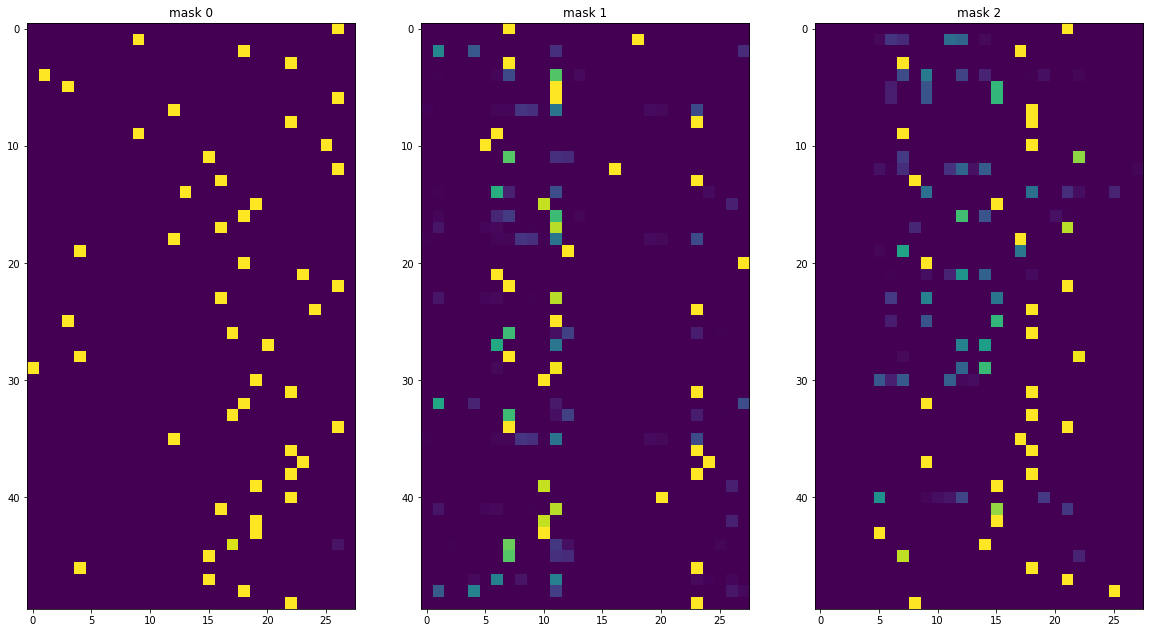

In [23]:
from matplotlib import pyplot as plt
explain_matrix, masks = clf.explain(X_test)

fig, axs = plt.subplots(1, 3, figsize=(20,20))
for i in range(3):
    axs[i].imshow(masks[i][:50])
    axs[i].set_title(f"mask {i}")